## This notebook deals with daily averaged data from the whole year

### I couldn't find mothly averaged data from the site, if found the job would have been wayy easier
### To run this code one needs to find the data from the following site


### More details of the data can be found in the Power point presentation attached
https://giovanni.gsfc.nasa.gov/giovanni/

PS: I have removed 5 data points from the dataset as the total went to 360 which is divisible by 30 
and it made the job way easier, I could have been a bit clever and made adjustments in the for loop,
by giving if and elif statement, but I thought it was easy to do it this way.

I'm sure there are better ways to do mothly averaging on a year long daily averaged data.\
If any suggestions, please feel free to find me in the mail below

karthik.sb0812@gmail.com

### To download the 365 data files with the links provided by the website is included in the end of this notebook, feel free to use it or else good luck clicking on the 365 links ;-)

In [2]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import os
from glob import glob
from scipy.stats import linregress, spearmanr, pearsonr
# from uncertainties import unumpy as up
from matplotlib.colors import LogNorm

In [4]:
# NO2 data file paths

path = glob("File_path")

In [5]:
# to get the keys of the data
print(Dataset(path[0]).variables.keys())
print("")
print(Dataset(path[0]).variables["ColumnAmountNO2TropCloudScreened"][:].shape)

dict_keys(['ColumnAmountNO2TropCloudScreened', 'lat', 'lon'])

(720, 1440)


In [6]:
# defining a function for a straight line
def line(x, m, c):
    return (m*x) + c

C:\Users\ksb99\AppData\Local\Temp\ipykernel_25592\3916505650.py:50: UserWarning: Warning: converting a masked element to nan.
  NO2 = np.asarray(NO2)
C:\Users\ksb99\AppData\Local\Temp\ipykernel_25592\3916505650.py:51: UserWarning: Warning: converting a masked element to nan.
  NO2_err = np.asarray(NO2_err)


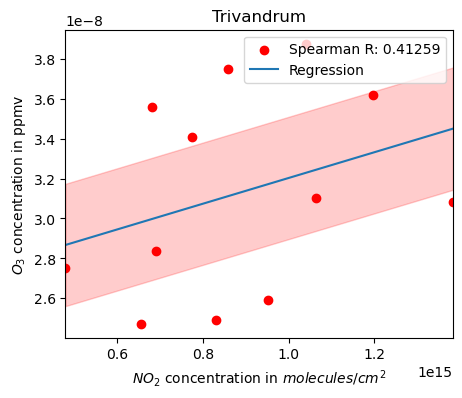

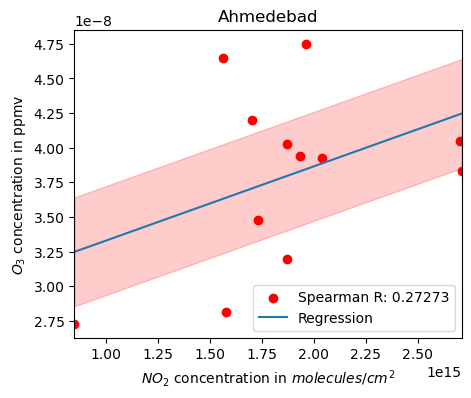

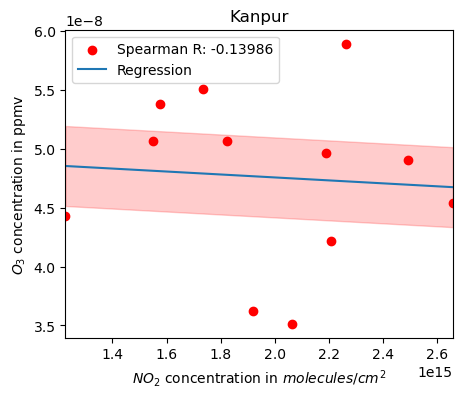

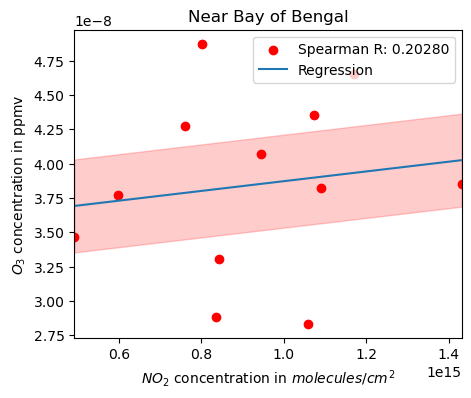

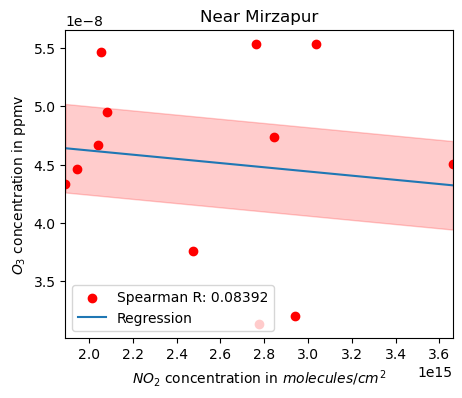

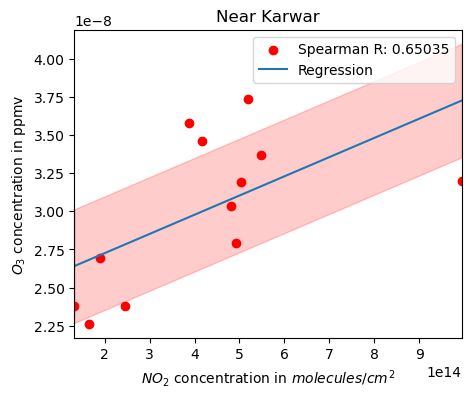

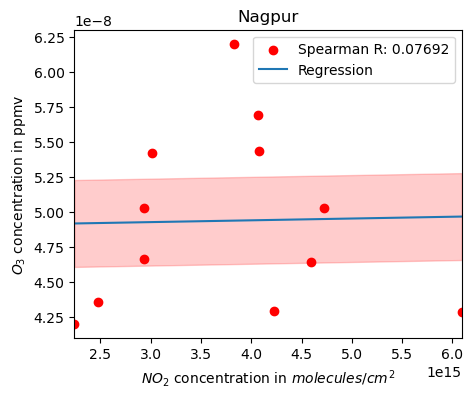

In [16]:
# I didn't paralellize this code, as it ended up eating more RAM in one of my previous project
# and I dont really do it unless it is absolutely necessary



# Define your data and coordinates as you did in your code
# trying for a for loop
names = ["Trivandrum", "Ahmedebad", "Kanpur", "Near Bay of Bengal", "Near Mirzapur", "Near Karwar", "Nagpur"]
# here first number is longitude and second is latitude
coordinates = [[77, 9], [72, 23], [80, 26], [90, 21], [82, 24], [73, 14], [79, 29]]

for q in range(len(coordinates)):
    
    target_latitude = coordinates[q][1]
    target_longitude = coordinates[q][0]
    fig, ax = plt.subplots(figsize=(5, 4))  # Create a single subplot for each location
    NO2 = []
    NO2_err = []

    
    for i in path:
        ds = Dataset(i)

        # Extract the latitude, longitude, and ozone data from the dataset
        latitude_data = ds.variables['lat'][:]
        longitude_data = ds.variables['lon'][:]
        NO_dat = ds.variables['ColumnAmountNO2TropCloudScreened'][:]

        # Find the indices of the target location
        lat_idx = np.abs(latitude_data - target_latitude).argmin()
        lon_idx = np.abs(longitude_data - target_longitude).argmin()

        # Define the indices for the 1 degree * 1 degree area
        lat_start_idx = max(0, int(lat_idx - 0.5))
        lat_end_idx = min(len(latitude_data), int(lat_idx + 0.5))+1
        lon_start_idx = max(0, int(lon_idx - 0.5))
        lon_end_idx = min(len(longitude_data), int(lon_idx + 0.5))+1
        
        NO_dat = NO_dat.copy()

        # Extract the ozone data for the specified area
        NO_area = NO_dat[lat_start_idx:lat_end_idx, lon_start_idx:lon_end_idx]

        # Calculate the average ozone concentration for each pressure level
        NO_area = NO_area.copy()
        NO2_vals = np.mean(NO_area)
        
        standard_deviation = np.std(NO_area, axis=(0,1), ddof=0)
        
        NO2.append(NO2_vals)
        NO2_err.append(standard_deviation)
        
    NO2 = np.asarray(NO2)
    NO2_err = np.asarray(NO2_err)
    NO2 = NO2.reshape(-1, 30)
    NO2_err = NO2_err.reshape(-1, 30)
    
    # there are some discrepencies in getting error matrices, feel free to edit this part to get it right
    # I was a bit lazy to correct it
    
#     err_matrix = up.umatrix(NO2.reshape(-1), NO2_err.reshape(-1))
#     err_matrix = err_matrix.reshape(-1, 30)
#     errors = np.nansum(err_matrix, axis=1)
    
    NO2_30 = np.nanmean(NO2, axis=1)
    NO2_err_30 = np.nanstd(NO2_err, axis=1)
    
    
    # this line imports the data saved in the project notebook 1
    # one can also get the code to load Ozone data from there and use it here
    O3 = np.load("Ozone_" + names[q] + " 2022.npy")
    O3_err = np.load("Ozone_errors" + names[q] + " 2022.npy")

    # Plotting the data
    stat, pval = spearmanr(NO2_30, O3, alternative="two-sided")
    x = np.linspace(np.amin(NO2_30), np.amax(NO2_30), len(NO2_30))  # Array for regression line
    
    slope, inter, _, _, _ = linregress(NO2_30, O3)
    y = line(x, slope, inter)
    
    sigma = np.sqrt(np.sum((y - O3)**2) / (len(NO2_30)))
   

    # plotting stuffs
    plt.scatter(NO2_30, O3, color='red', label="Spearman R: %.5f" %stat)
    plt.plot(x, y, label="Regression")  # Regression line
    plt.fill_between(x, y+(sigma/2), y-(sigma/2), alpha=0.2, color="red")
    plt.xlabel("$NO_2$ concentration in $molecules/cm^2$")
    plt.ylabel("$O_3$ concentration in ppmv")
    plt.legend()
    plt.xlim(np.min(x), np.max(x))
    plt.title(names[q])

    # Save the individual subplot as an image
#     plt.savefig("SAVE_DIRECTORY" % names[q], dpi=100)
#     plt.close()  # Close the current figure to avoid saving empty layouts

plt.show()  # This line can stay outside the loop


## Fetcher code

In [18]:
import webbrowser

In [21]:
# all this code does is, it opens the links saved in the text file with the links
# The code credit goes to my pal Sarwin Deon

def open_urls_in_browser(file_path, max_ind, min_ind):
    try:
        with open(file_path, 'r') as file:
            urls = file.read().splitlines()

            max_ind = min(max_ind, len(urls))
            min_ind = max(min_ind, 0)

            for i in range(min_ind, max_ind):
                url = urls[i]
                print(f"Opening URL {i + 1}: {url}")
                webbrowser.open(url)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    file_path = "FILE_NAME.txt"  # Replace with name of doc, or copy all the urls, paste it in a file with this name.
    min_ind = 0  # Minimum, if you specify 10, it will download from 11th file onwards
    max_ind = 1  # Replace with max number needed, put some crazy big number to download all

    open_urls_in_browser(file_path, max_ind, min_ind)

Opening URL 1: https://acdisc.gesdisc.eosdis.nasa.gov:443/opendap/HDF-EOS5/ncml/Aura_OMI_Level3/OMNO2d.003/2022/OMI-Aura_L3-OMNO2d_2022m0101_v003-2022m0330t221216.he5.ncml.nc?ColumnAmountNO2TropCloudScreened%5B0%3A719%5D%5B0%3A1439%5D%2Clat%5B0%3A719%5D%2Clon%5B0%3A1439%5D


In [20]:
cd

C:\Users\ksb99
